In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install ultralytics

# **Final code: Video Analytics Specific Object**



```
Guidance

1. User Input: Specific object
2. Specific Object detection, Speed and distance estimation
3. Graph Analytics: Pie, Area, Multi-Class line

```




# ***Helper function***

In [ ]:
def create_pie_chart(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    ax.pie(data.values(), labels=data.keys(), autopct='%1.1f%%')
    ax.legend()
    ax.set_title("Total Percentage of Individual Class Perspective")
    plt.close(fig)
    return fig

def create_area_plot(class_counts_over_time):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    sorted_keys = sorted(class_counts_over_time.keys())
    for cls in sorted_keys:
        ax.fill_between(range(len(class_counts_over_time[cls])), class_counts_over_time[cls], label=cls, alpha=0.6)
    ax.legend()
    ax.set_title("Distribution of Each Class Over Time")
    ax.set_xlabel("Frame Count")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def create_multiple_line_plot(speed_data, distance_data, frame_count):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    for track_id in speed_data.keys():
        ax.plot(range(frame_count), speed_data[track_id], label=f"Speed {track_id}")
    for track_id in distance_data.keys():
        ax.plot(range(frame_count), distance_data[track_id], label=f"Distance {track_id}")
    ax.legend()
    ax.set_title("Speed and Distance Identification of Each Class")
    ax.set_xlabel("Frame Count")
    ax.set_ylabel("Value")
    plt.close(fig)
    return fig

def create_scatter_plot(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    x = list(data.keys())
    y = list(data.values())
    ax.scatter(x, y)
    ax.set_title("Class Distribution Scatter Plot")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def fig_to_img(fig):
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return img

def resize_and_place_image(base_image, overlay_image, position):
    overlay_image_resized = cv2.resize(overlay_image, (w // 3, h // 3))
    x, y = position
    base_image[y:y + overlay_image_resized.shape[0], x:x + overlay_image_resized.shape[1]] = overlay_image_resized
    return base_image

def draw_visualizations(frame, data, labels, speed_data, distance_data, class_counts_over_time, frame_count):
    vis_frame = np.zeros((h, w // 3, 3), dtype=np.uint8)

    # Create Pie Chart
    if data:
        pie_chart = create_pie_chart(data)
        pie_chart_img = fig_to_img(pie_chart)
        vis_frame = resize_and_place_image(vis_frame, pie_chart_img, (0, 0))

    # Create Area Plot
    if class_counts_over_time:
        area_plot = create_area_plot(class_counts_over_time)
        area_plot_img = fig_to_img(area_plot)
        vis_frame = resize_and_place_image(vis_frame, area_plot_img, (0, h // 3))

    # Create Multiple Line Plot
    if speed_data or distance_data:
        line_plot = create_multiple_line_plot(speed_data, distance_data, frame_count)
        line_plot_img = fig_to_img(line_plot)
        vis_frame = resize_and_place_image(vis_frame, line_plot_img, (0, 2 * (h // 3)))

    combined_frame = np.hstack((frame, vis_frame))
    return combined_frame

def pad_lists_to_length(data_dict, length, default_value=0):
    for key in data_dict.keys():
        if len(data_dict[key]) < length:
            data_dict[key] += [default_value] * (length - len(data_dict[key]))

# Specific input based video analytics (object count, speed, distance estimation..)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Example input: horse:17, person: 0,car: 2, van: 8,bus: 5,tree: 62
Enter desired classes with their IDs (format: 'class1:id1,class2:id2,...'): horse:17, person: 0,car: 2
Desired classes: {'horse': 17, 'person': 0, 'car': 2}

0: 384x640 3 horses, 170.4ms
Speed: 2.9ms preprocess, 170.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 343.2ms
Speed: 2.5ms preprocess, 343.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 horses, 130.8ms
Speed: 2.6ms preprocess, 130.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 345.5ms
Speed: 2.7ms preprocess, 345.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 horses, 126.6ms
Speed: 2.6ms preprocess, 126.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 horses, 1 elephant

KeyboardInterrupt: 

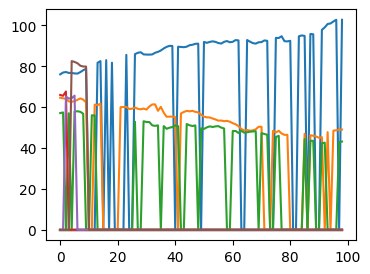

In [10]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from ultralytics.solutions import speed_estimation

# Initialize YOLO models
object_detection_model = YOLO("yolov8s.pt")
speed_estimation_model = YOLO("yolov8n.pt")
names = speed_estimation_model.model.names

# Open video file
cap = cv2.VideoCapture("/content/drive/MyDrive/yolo/race.mp4")
assert cap.isOpened(), "Error reading video file"

# Get video properties
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Initialize video writer
out = cv2.VideoWriter("Distribution_speed_distance_visual_scatter_unique1hor_car_overall.avi", cv2.VideoWriter_fourcc(*"MJPG"),15, (w + w // 3, h))

frame_count = 0
data = {}
labels = []
class_counts_over_time = {}
speed_over_time = {}
distance_over_time = {}

# Center point and pixel per meter for distance calculation
center_point = (0, h)
pixel_per_meter = 10

# Line points for speed estimation
line_pts = [(0, 360), (1280, 360)]

# Initialize speed-estimation object
speed_obj = speed_estimation.SpeedEstimator(names=names, reg_pts=line_pts, view_img=False)

# Colors for text and bounding box
txt_color, txt_background, bbox_clr = ((0, 0, 0), (255, 255, 255), (255, 0, 255))

print('Example input: horse:17, person: 0,car: 2, van: 8,bus: 5,tree: 62')
# Allow user to input desired classes
user_input = input("Enter desired classes with their IDs (format: 'class1:id1,class2:id2,...'): ")
# Example input: "person:0,car:2,horse:17"
desired_classes = {}
for item in user_input.split(','):
    cls, cls_id = item.split(':')
    desired_classes[cls.strip()] = int(cls_id.strip())

print("Desired classes:", desired_classes)

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_count += 1

    # Object detection for speed estimation
    speed_tracks = speed_estimation_model.track(frame, persist=True, show=False)
    frame = speed_obj.estimate_speed(frame, speed_tracks)

    # Object detection for distance estimation
    annotator = Annotator(frame, line_width=2)
    results = object_detection_model.track(frame, persist=True)

    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        clss = results[0].boxes.cls.cpu().tolist()

        for box, track_id, cls in zip(boxes, track_ids, clss):
            cls_name = object_detection_model.names[int(cls)]
            if cls_name in desired_classes and desired_classes[cls_name] == cls:  # Filter desired classes and IDs
                if cls_name not in labels:
                    labels.append(cls_name)

                if cls_name in data:
                    data[cls_name] += 1
                else:
                    data[cls_name] = 1

                annotator.box_label(box, label=str(track_id), color=bbox_clr)
                annotator.visioneye(box, center_point)

                x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)  # Bounding box centroid

                distance = (math.sqrt((x1 - center_point[0]) ** 2 + (y1 - center_point[1]) ** 2)) / pixel_per_meter

                text_size, _ = cv2.getTextSize(f"Distance: {distance:.2f} m", cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
                cv2.rectangle(frame, (x1, y1 - text_size[1] - 10), (x1 + text_size[0] + 10, y1), txt_background, -1)
                cv2.putText(frame, f"Distance: {distance:.2f} m", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2, txt_color, 3)

                if track_id not in distance_over_time:
                    distance_over_time[track_id] = [0] * (frame_count - 1)
                distance_over_time[track_id].append(distance)

                speed = speed_obj.speeds.get(track_id, 0) if hasattr(speed_obj, 'speeds') else 0
                if track_id not in speed_over_time:
                    speed_over_time[track_id] = [0] * (frame_count - 1)
                speed_over_time[track_id].append(speed)

                if cls_name not in class_counts_over_time:
                    class_counts_over_time[cls_name] = [0] * frame_count
                if len(class_counts_over_time[cls_name]) < frame_count:
                    class_counts_over_time[cls_name].extend([0] * (frame_count - len(class_counts_over_time[cls_name])))
                class_counts_over_time[cls_name][-1] += 1

    # Pad lists to current frame count to ensure equal lengths
    pad_lists_to_length(distance_over_time, frame_count)
    pad_lists_to_length(speed_over_time, frame_count)

    # Draw combined visualizations on the frame
    combined_frame = draw_visualizations(frame, data, labels, speed_over_time, distance_over_time, class_counts_over_time, frame_count)

    # Write the frame with visualizations
    out.write(combined_frame)

    # Clear counts for next frame
    data = {}

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Generate and overlay scatter plot on the final frame
final_frame = np.zeros((h, w, 3), dtype=np.uint8)
scatter_plot = create_scatter_plot(class_counts_over_time)
scatter_plot_img = fig_to_img(scatter_plot)
final_frame = resize_and_place_image(final_frame, scatter_plot_img, (0, 0))

# Save the final frame with the scatter plot
cv2.imwrite("final_frame_with_scatter_plot.png", final_frame)

cap.release()
out.release()
cv2.destroyAllWindows()

# Print overall analytics
total_counts = sum(sum(counts) for counts in class_counts_over_time.values())
print(f"Overall total count: {total_counts}")
for cls, counts in class_counts_over_time.items():
    print(f"Total count for {cls}: {sum(counts)}")

best_speed = max((max(speeds) for speeds in speed_over_time.values()), default=0)
print(f"Overall best speed: {best_speed} m/s")
best_distance = max((max(distances) for distances in distance_over_time.values()), default=0)
print(f"Overall best distance: {best_distance} meters")


# ***Below all code are demo and tried code, step by step implementation (June 5 to June 8,2024)***

# Initial try




In [3]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from ultralytics.solutions import speed_estimation

# Initialize YOLO models
object_detection_model = YOLO("yolov8s.pt")
speed_estimation_model = YOLO("yolov8n.pt")
names = speed_estimation_model.model.names

# Open video file
cap = cv2.VideoCapture("/content/drive/MyDrive/yolo/h1.mp4")
assert cap.isOpened(), "Error reading video file"

# Get video properties
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Initialize video writer
out = cv2.VideoWriter("Distribution_speed_distance_visual_scatter_unique1hor_car.avi", cv2.VideoWriter_fourcc(*"MJPG"), 25, (w + w // 3, h))

frame_count = 0
data = {}
labels = []
class_counts_over_time = {}
speed_over_time = {}
distance_over_time = {}

# Center point and pixel per meter for distance calculation
center_point = (0, h)
pixel_per_meter = 10

# Line points for speed estimation
line_pts = [(0, 360), (1280, 360)]

# Initialize speed-estimation object
speed_obj = speed_estimation.SpeedEstimator(names=names, reg_pts=line_pts, view_img=False)

# Colors for text and bounding box
txt_color, txt_background, bbox_clr = ((0, 0, 0), (255, 255, 255), (255, 0, 255))

def create_pie_chart(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    ax.pie(data.values(), labels=data.keys(), autopct='%1.1f%%')
    ax.legend()
    ax.set_title("Total Percentage of Individual Class Perspective")
    plt.close(fig)
    return fig

def create_bar_plot(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    colors = plt.cm.get_cmap('tab10', len(data))  # Use 'tab20' colormap
    ax.bar(data.keys(), data.values(), color=[colors(i) for i in range(len(data))])
    ax.legend()
    ax.set_title("Distribution of Each Class")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def create_multiple_line_plot(speed_data, distance_data, frame_count):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    for track_id in speed_data.keys():
        ax.plot(range(frame_count), speed_data[track_id], label=f"Speed {track_id}")
    for track_id in distance_data.keys():
        ax.plot(range(frame_count), distance_data[track_id], label=f"Distance {track_id}")
    ax.legend()
    ax.set_title("Speed and Distance Identification of Each Class")
    ax.set_xlabel("Frame Count")
    ax.set_ylabel("Value")
    plt.close(fig)
    return fig

def create_scatter_plot(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    x = list(data.keys())
    y = list(data.values())
    ax.scatter(x, y)
    ax.set_title("Class Distribution Scatter Plot")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def fig_to_img(fig):
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return img

def resize_and_place_image(base_image, overlay_image, position):
    overlay_image_resized = cv2.resize(overlay_image, (w // 3, h // 3))
    x, y = position
    base_image[y:y + overlay_image_resized.shape[0], x:x + overlay_image_resized.shape[1]] = overlay_image_resized
    return base_image

def draw_visualizations(frame, data, labels, speed_data, distance_data, frame_count):
    vis_frame = np.zeros((h, w // 3, 3), dtype=np.uint8)

    # Create Pie Chart
    if data:
        pie_chart = create_pie_chart(data)
        pie_chart_img = fig_to_img(pie_chart)
        vis_frame = resize_and_place_image(vis_frame, pie_chart_img, (0, 0))

    # Create Bar Plot
    if data:
        bar_plot = create_bar_plot(data)
        bar_plot_img = fig_to_img(bar_plot)
        vis_frame = resize_and_place_image(vis_frame, bar_plot_img, (0, h // 3))

    # Create Multiple Line Plot
    if speed_data or distance_data:
        line_plot = create_multiple_line_plot(speed_data, distance_data, frame_count)
        line_plot_img = fig_to_img(line_plot)
        vis_frame = resize_and_place_image(vis_frame, line_plot_img, (0, 2 * (h // 3)))

    combined_frame = np.hstack((frame, vis_frame))
    return combined_frame

def pad_lists_to_length(data_dict, length, default_value=0):
    for key in data_dict.keys():
        if len(data_dict[key]) < length:
            data_dict[key] += [default_value] * (length - len(data_dict[key]))

# Define the desired classes and their corresponding IDs
#desired_classes = {'person': 0, 'car': 2, 'horse': 17}
desired_classes = {'horse':17, 'person': 0,'car': 2, 'van': 8,'bus': 5,'tree': 62}

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_count += 1

    # Object detection for speed estimation
    speed_tracks = speed_estimation_model.track(frame, persist=True, show=False)
    frame = speed_obj.estimate_speed(frame, speed_tracks)

    # Object detection for distance estimation
    annotator = Annotator(frame, line_width=2)
    results = object_detection_model.track(frame, persist=True)

    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        clss = results[0].boxes.cls.cpu().tolist()

        for box, track_id, cls in zip(boxes, track_ids, clss):
            cls_name = object_detection_model.names[int(cls)]
            if cls_name in desired_classes and desired_classes[cls_name] == cls:  # Filter desired classes and IDs
                if cls_name not in labels:
                    labels.append(cls_name)

                if cls_name in data:
                    data[cls_name] += 1
                else:
                    data[cls_name] = 1

                annotator.box_label(box, label=str(track_id), color=bbox_clr)
                annotator.visioneye(box, center_point)

                x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)  # Bounding box centroid

                distance = (math.sqrt((x1 - center_point[0]) ** 2 + (y1 - center_point[1]) ** 2)) / pixel_per_meter

                text_size, _ = cv2.getTextSize(f"Distance: {distance:.2f} m", cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
                cv2.rectangle(frame, (x1, y1 - text_size[1] - 10), (x1 + text_size[0] + 10, y1), txt_background, -1)
                cv2.putText(frame, f"Distance: {distance:.2f} m", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2, txt_color, 3)

                if track_id not in distance_over_time:
                    distance_over_time[track_id] = [0] * (frame_count - 1)
                distance_over_time[track_id].append(distance)

                speed = speed_obj.speeds.get(track_id, 0) if hasattr(speed_obj, 'speeds') else 0
                if track_id not in speed_over_time:
                    speed_over_time[track_id] = [0] * (frame_count - 1)
                speed_over_time[track_id].append(speed)

    # Pad lists to current frame count to ensure equal lengths
    pad_lists_to_length(distance_over_time, frame_count)
    pad_lists_to_length(speed_over_time, frame_count)

    # Draw combined visualizations on the frame
    combined_frame = draw_visualizations(frame, data, labels, speed_over_time, distance_over_time, frame_count)

    # Write the frame with visualizations
    out.write(combined_frame)

    # Clear counts for next frame
    data = {}

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Generate and overlay scatter plot on the final frame
final_frame = np.zeros((h, w, 3), dtype=np.uint8)
scatter_plot = create_scatter_plot(class_counts_over_time)
scatter_plot_img = fig_to_img(scatter_plot)
final_frame = resize_and_place_image(final_frame, scatter_plot_img, (0, 0))


# Save the final frame with the scatter plot
cv2.imwrite("final_frame_with_scatter_plot.png", final_frame)

cap.release()
out.release()
cv2.destroyAllWindows()


100%|██████████| 21.5M/21.5M [00:00<00:00, 181MB/s]


100%|██████████| 6.23M/6.23M [00:00<00:00, 79.7MB/s]


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.9s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


0: 384x640 (no detections), 223.8ms
Speed: 5.6ms preprocess, 223.8ms inference, 115.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 89.9ms
Speed: 1.4ms preprocess, 89.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.4ms
Speed: 1.0ms preprocess, 10.

<ipython-input-3-b324199ea2fc>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(data))  # Use 'tab20' colormap



0: 384x640 1 horse, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.7ms
Speed: 6.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.3ms
Speed: 4.4ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.8ms
Speed: 1.5ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 17.3ms
Speed: 4.6ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.9ms
Speed: 5.7ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.0ms
Speed: 1.3ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.8ms
Speed: 4.6ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.8ms
Speed: 6.0ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 elephant, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 15.6ms
Speed: 4.1ms preprocess, 15.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.6ms
Speed: 2.6ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.6ms
Speed: 1.2ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.8ms
Speed: 1.2ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 4.2ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 16.8ms
Speed: 1.1ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.4ms
Speed: 4.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 8.2ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.9ms
Speed: 4.1ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.9ms
Speed: 2.4ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 3.9ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.5ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.4ms
Speed: 6.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 21.1ms
Speed: 3.5ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 5.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.5ms
Speed: 5.6ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.7ms
Speed: 4.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 1 elephant, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.7ms
Speed: 2.3ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 1 elephant, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 17.5ms
Speed: 1.1ms preprocess, 17.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.1ms
Speed: 2.4ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.6ms
Speed: 1.2ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.8ms
Speed: 1.1ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 6.6ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 17.5ms
Speed: 1.1ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.3ms preprocess, 12.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.9ms
Speed: 7.3ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.7ms
Speed: 2.4ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.5ms
Speed: 1.3ms preprocess, 13.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 12.8ms
Speed: 1.2ms preprocess, 12.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.9ms
Speed: 1.1ms preprocess, 13.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.6ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 7.1ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.1ms
Speed: 5.1ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.2ms
Speed: 5.9ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.4ms
Speed: 5.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 7.8ms
Speed: 4.9ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 11.7ms
Speed: 1.0ms preprocess, 11.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 11.4ms
Speed: 1.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 7.0ms
Speed: 6.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.2ms
Speed: 5.5ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 7.2ms
Speed: 6.5ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 7.4ms
Speed: 5.0ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 elephant, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 1 elephant, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 1 tv, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 10.0ms
Speed: 6.2ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 10.8ms
Speed: 4.3ms preprocess, 10.8ms infer


0: 384x640 1 person, 1 traffic light, 1 fire hydrant, 16.8ms
Speed: 2.3ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 2 horses, 10.1ms
Speed: 2.4ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.9ms
Speed: 2.2ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 19.7ms
Speed: 1.2ms preprocess, 19.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 20.2ms
Speed: 1.1ms preprocess, 20.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.7ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 traffic light, 1 horse, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 traffic light, 4 horses, 12.3ms
Speed: 1.5ms preprocess, 12.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 horses, 12.3ms
Speed: 1.5ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 1 elephant, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 2 elephants, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 2.5ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 1 elephant, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 7.4ms
Speed: 5.3ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 12.9ms
Speed: 1.1ms preprocess, 12.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.0ms
Speed: 1.1ms preprocess, 13.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.5ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 truck, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 dog, 1 cow, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 birds, 13.0ms
Speed: 1.2ms preprocess, 13.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 boat, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 truck, 12.9ms
Speed: 1.3ms preprocess, 12.9ms inference, 1.2ms pos


0: 384x640 1 person, 1 horse, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.2ms
Speed: 1.1ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 23.6ms
Speed: 5.1ms preprocess, 23.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 21.2ms
Speed: 1.5ms preprocess, 21.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.4ms
Speed: 2.3ms preprocess, 14.4ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.4ms
Speed: 1.4ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 18.6ms
Speed: 2.6ms preprocess, 18.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 43.8ms
Speed: 1.3ms preprocess, 43.8ms inference, 9.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 2.4ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.7ms
Speed: 1.2ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 7.2ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 27.1ms
Speed: 1.2ms preprocess, 27.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 1 horse, 20.0ms
Speed: 4.9ms preprocess, 20.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 horse, 1 elephant, 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 25.1ms
Speed: 2.0ms preprocess, 25.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 19.1ms
Speed: 1.3ms preprocess, 19.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 1 cow, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 4.9ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.0ms
Speed:


0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 car, 1 traffic light, 13.7ms
Speed: 1.0ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.5ms
Speed: 1.1ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 55.9ms
Speed: 6.2ms preprocess, 55.


0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.9ms
Speed: 1.3ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.1ms
Speed: 1.1ms preprocess, 13.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 3.8ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.1ms p


0: 384x640 2 persons, 2 horses, 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 16.7ms
Speed: 4.6ms preprocess, 16.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 elephant, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 traffic light, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 elephant, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 airplane, 1 traffic light, 1 horse, 2 elephants, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 elephant, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 2 traffic lights, 1 bear, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 train, 1 horse, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 4 persons, 1 car, 3 fire hydrants, 1 elephant, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.8ms
Speed: 1.6ms preprocess, 13.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.6ms
Speed: 5.1ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.6ms
Speed: 2.3ms preprocess, 13.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.3ms
Speed: 1.4ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 13.4ms
Speed: 2.4ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 12.9ms
Speed: 1.4ms preprocess, 12.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 7.5ms
Speed: 4.7ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 2 cows, 2 kites, 13.0ms
Speed: 1.3ms preprocess, 13.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 horses, 2 cows, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference


0: 384x640 1 horse, 10.0ms
Speed: 4.3ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 13.2ms
Speed: 3.5ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 elephant, 9.3ms
Speed: 11.1ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.5ms
Speed: 1.2ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.4ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 elephant, 13.4ms
Speed: 1.1ms preprocess, 13.4ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.1ms
Speed: 2.3ms preprocess, 14.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 elephant, 17.7ms
Speed: 1.2ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.2ms
Speed: 4.6ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 16.4ms
Speed: 1.4ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.6ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.5ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 7.9ms
Speed: 4.5ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.4ms
Speed: 4.0ms preprocess, 8.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 horses, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 2 horses, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.7ms
Speed: 2.8ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.0ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 19.2ms
Speed: 1.1ms preprocess, 19.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.1ms
Speed: 2.7ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.2ms
Speed: 2.3ms preprocess, 13.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 4.5ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.5ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.1ms
Speed: 3.9ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 4.1ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.6ms
Speed: 1.3ms preprocess, 14.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.4ms
Speed: 1.1ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.5ms preprocess, 12.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.0ms
Speed: 1.1ms preprocess, 13.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.8ms
Speed: 1.1ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.2ms
Speed: 4.3ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 3.3ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 3.1ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 3.3ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.1ms
Speed: 1.7ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.0ms
Speed: 4.8ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.9ms
Speed: 1.1ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.1ms
Speed: 2.2ms preprocess, 15.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 4.7ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 4.9ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.3ms
Speed: 1.1ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.6ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.8ms
Speed: 1.1ms preprocess, 13.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.7ms
Speed: 2.1ms preprocess, 14.7ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.3ms
Speed: 1.1ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 18.2ms
Speed: 1.1ms preprocess, 18.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.7ms
Speed: 2.2ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.3ms
Speed: 1.2ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.3ms
Speed: 2.2ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 20.7ms
Speed: 1.1ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.5ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.5ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.6ms
Speed: 1.2ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 4.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 3.5ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.1ms
Speed: 1.2ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.3ms
Speed: 5.0ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 13.4ms
Speed: 1.2ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.9ms
Speed: 1.5ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 horse, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.4ms
Speed: 1.6ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.0ms
Speed: 2.5ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.7ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.1ms
Speed: 1.3ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 1 horse, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.9ms
Speed: 1.1ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.8ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.7ms
Speed: 1.3ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 3.7ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 elephant, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.8ms
Speed: 1.4ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.6ms
Speed: 1.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.4ms
Speed: 3.3ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.3ms
Speed: 2.3ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.5ms
Speed: 1.3ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 4.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.8ms
Speed: 5.2ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.8ms
Speed: 1.1ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.8ms
Speed: 1.2ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 3.3ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.6ms
Speed: 1.1ms preprocess, 15.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.4ms
Speed: 1.1ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.6ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 3.4ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 6.1ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 3.2ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.4ms
Speed: 1.1ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 elephant, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 elephant, 17.4ms
Speed: 11.2ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 elephant, 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.9ms
Speed: 2.2ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.4ms
Speed: 1.1ms preprocess, 14.4ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.5ms
Speed: 2.2ms preprocess, 14.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 3.5ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.4ms
Speed: 1.4ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.5ms
Speed: 1.1ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.2ms
Speed: 2.5ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.1ms
Speed: 1.2ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.6ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.7ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.7ms
Speed: 1.1ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.5ms
Speed: 1.2ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.2ms
Speed: 2.2ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.2ms
Speed: 2.7ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.0ms
Speed: 1.1ms preprocess, 14.0ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.3ms
Speed: 1.4ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.2ms
Speed: 1.1ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 3.2ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 3.4ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.6ms
Speed: 1.2ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.0ms
Speed: 2.6ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.0ms
Speed: 3.6ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.5ms
Speed: 1.2ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.4ms
Speed: 1.2ms preprocess, 13.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.2ms
Speed: 1.6ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.1ms
Speed: 2.3ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.6ms
Speed: 1.7ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.6ms
Speed: 2.3ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.7ms
Speed: 2.2ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.0ms
Speed: 1.2ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.9ms
Speed: 1.2ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 truck, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 elephant, 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.6ms
Speed: 2.5ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.5ms
Speed: 1.2ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 15.9ms
Speed: 2.6ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.5ms
Speed: 1.1ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 15.5ms
Speed: 2.4ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.3ms
Speed: 2.7ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.2ms
Speed: 3.0ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.3ms
Speed: 3.2ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 horses, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.7ms postprocess per image 


0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.3ms
Speed: 2.7ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 15.2ms
Speed: 1.1ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.2ms
Speed: 2.3ms preprocess, 13.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 17.0ms
Speed: 1.3ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 14.6ms
Speed: 1.3ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cows, 10.3ms
Speed: 5.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 1 cow, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 giraffe, 14.0ms
Speed: 2.2ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cow, 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.4ms postprocess per imag


0: 384x640 1 horse, 17.6ms
Speed: 2.3ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.0ms
Speed: 1.1ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 fire hydrant, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.0ms
Speed: 2.7ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.6ms
Speed: 1.1ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 13.3ms
Speed: 3.1ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 elephant, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cow, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.6ms
Speed: 1.0ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.5ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.0ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.5ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.6ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 elephant, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.1ms
Speed: 1.1ms preprocess, 13.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.4ms
Speed: 1.2ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.9ms
Speed: 1.2ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 17.1ms
Speed: 2.5ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.3ms
Speed: 1.3ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 4.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 2 cars, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 boat, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cows, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cows, 1 elephant, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inferen


0: 384x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 14.2ms
Speed: 2.4ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.1ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bear, 11.3ms
Speed: 3.1ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 22.3ms
Speed: 1.2ms preprocess, 22.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 13.0ms
Speed: 2.8ms preprocess, 13.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.5ms
Speed: 1.1ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bear, 11.7ms
Speed: 1.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.0ms
Speed: 1.3ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 12.9ms
Speed: 1.3ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 15.4ms
Speed: 2.4ms preprocess, 15.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.6ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.1ms
Speed: 2.4ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.6ms
Speed: 1.3ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.9ms
Speed: 2.5ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.9ms
Speed: 1.3ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.2ms
Speed: 2.6ms preprocess, 10.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.0ms
Speed: 1.3ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.2ms
Speed: 2.6ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 14.9ms
Speed: 4.9ms preprocess, 14.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.0ms
Speed: 1.2ms preprocess, 15.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.5ms
Speed: 2.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.7ms
Speed: 2.4ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.3ms
Speed: 3.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.2ms
Speed: 2.6ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.0ms
Speed: 8.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.7ms
Speed: 2.6ms preprocess, 11.7ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 12.4ms
Speed: 1.7ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 17.2ms
Speed: 2.3ms preprocess, 17.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 vase, 43.7ms
Speed: 3.7ms preprocess, 43.7ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 13.8ms
Speed: 1.2ms preprocess, 13.8ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.3ms
Speed: 1.5ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13.8ms
Speed: 1.1ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 17.5ms
Speed: 4.3ms preprocess, 17.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bicycle, 13.0ms
Speed: 1.1ms preprocess, 13.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.9ms
Speed: 1.0ms preprocess, 13.9ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.5ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.7ms
Speed: 1.1ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 3.4ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.9ms
Speed: 1.2ms preprocess, 14.9ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 0.9ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.2ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 5.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.1ms
Speed: 1.3ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.5ms
Speed: 2.5ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.2ms
Speed: 1.2ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.6ms
Speed: 1.1ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.7ms
Speed: 1.4ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.6ms
Speed: 1.4ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.5ms
Speed: 3.7ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.2ms
Speed: 2.4ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.3ms
Speed: 1.0ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 16.8ms
Speed: 2.3ms preprocess, 16.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.2ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.4ms
Speed: 1.4ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.1ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 2.5ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.8ms
Speed: 2.8ms preprocess, 12.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.4ms
Speed: 1.3ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.2ms
Speed: 2.4ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 10.8ms
Speed: 3.2ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.0ms
Speed: 1.4ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.9ms
Speed: 1.0ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 3.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.2ms
Speed: 1.1ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.9ms
Speed: 1.1ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.6ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.4ms
Speed: 1.0ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 14.6ms
Speed: 2.7ms preprocess, 14.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.4ms
Speed: 8.1ms preprocess, 12.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.0ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.7ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.3ms
Speed: 1.1ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.4ms
Speed: 2.7ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 19.6ms
Speed: 1.2ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.6ms
Speed: 1.1ms preprocess, 12.6ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 18.4ms
Speed: 2.3ms preprocess, 18.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.2ms
Speed: 1.0ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 16.2ms
Speed: 1.8ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 13.7ms
Speed: 2.7ms preprocess, 13.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.2ms
Speed: 2.5ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.5ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 3.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.5ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.0ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.8ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 3.1ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.9ms
Speed: 4.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.4ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.0ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 18.2ms
Speed: 2.2ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.7ms
Speed: 1.0ms preprocess, 13.7ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.9ms
Speed: 2.3ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.4ms
Speed: 8.8ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.5ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 3.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.3ms
Speed: 1.6ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.8ms
Speed: 8.0ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 bicycle, 10.3ms
Speed: 8.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 6.3ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.3ms
Speed: 2.3ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.5ms
Speed: 2.2ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.4ms
Speed: 1.0ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.1ms
Speed: 1.1ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.7ms
Speed: 2.3ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.2ms
Speed: 2.5ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.3ms
Speed: 1.2ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.7ms
Speed: 1.0ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.0ms
Speed: 3.5ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 motorcycle, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.7ms
Speed: 2.4ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 16.7ms
Speed: 1.1ms preprocess, 16.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.6ms
Speed: 1.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 17.0ms
Speed: 2.1ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.6ms
Speed: 4.8ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.6ms
Speed: 1.1ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.6ms
Speed: 1.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.4ms
Speed: 1.3ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 13.5ms
Speed: 3.7ms preprocess, 13.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.0ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 3.4ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.9ms
Speed: 1.2ms preprocess, 13.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 1 elephant, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 10.9ms
Speed: 1.2ms preprocess


0: 384x640 1 person, 1 horse, 20.2ms
Speed: 2.8ms preprocess, 20.2ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 18.0ms
Speed: 1.2ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 1 elephant, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.0ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.7ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.4ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.5ms
Speed: 2.5ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.2ms
Speed: 1.3ms preprocess, 13.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.7ms
Speed: 2.3ms preprocess, 16.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 16.2ms
Speed: 2.4ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.9ms
Speed: 1.1ms preprocess, 13.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.1ms
Speed: 4.3ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.4ms
Speed: 1.3ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 traffic light, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.0ms
Speed: 2.4ms preprocess, 13.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 1 cow, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 14.3ms
Speed: 1.4ms preprocess, 14.3ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 4 persons, 2 cars, 1 horse, 13.6ms
Speed: 2.2ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 horses, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 15.4ms
Speed: 4.0ms preprocess, 15.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 8.4ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.7ms
Speed: 1.3ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.7ms
Speed: 3.0ms preprocess, 12.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.3ms
Speed: 3.6ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.5ms
Speed: 1.3ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.9ms
Speed: 3.4ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.0ms
Speed: 3.3ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.0ms
Speed: 2.7ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.1ms
Speed: 10.0ms preprocess, 12.1ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.9ms
Speed: 1.3ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.6ms
Speed: 1.3ms preprocess, 14.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 16.3ms
Speed: 1.2ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.5ms
Speed: 3.7ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 16.2ms
Speed: 1.2ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.6ms
Speed: 7.8ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.4ms
Speed: 1.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bird, 9.6ms
Speed: 3.5ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.4ms
Speed: 1.1ms preprocess, 15.4ms inference, 1.8ms postpr


0: 384x640 (no detections), 11.9ms
Speed: 2.6ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 2 cows, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 horses, 10.2ms
Speed: 2.4ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.6ms postprocess 


0: 384x640 1 person, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 15.5ms
Speed: 2.3ms preprocess, 15.5ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 18.6ms
Speed: 1.3ms preprocess, 18.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.4ms
Speed: 2.3ms preprocess, 13.4ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.7ms
Speed: 2.2ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.6ms postprocess 


0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.5ms
Speed: 3.6ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.7ms
Speed: 2.6ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.2ms
Speed: 1.5ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.5ms
Speed: 2.4ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.0ms
Speed: 2.3ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 4.2ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.0ms
Speed: 1.1ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.7ms
Speed: 1.5ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 cow, 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 3.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 11.2ms
Speed: 3.5ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 cow, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 cars, 1 airplane, 11.9ms
Speed: 4.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 16.4ms
Speed: 2.7ms preprocess, 16.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 boat, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 boats, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 boat, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 0.7ms postproc


0: 384x640 1 person, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.4ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 3.2ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.5ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.6ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.2ms
Speed: 1.1ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.5ms
Speed: 2.3ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.0ms
Speed: 1.3ms preprocess, 13.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 2 horses, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 2 horses, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.4ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.7ms
Speed: 3.1ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.6ms
Speed: 1.4ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.4ms
Speed: 1.1ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.1ms
Speed: 2.2ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 25.4ms
Speed: 6.0ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 28.5ms
Speed: 1.3ms preprocess, 28.5ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 4.5ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 3.2ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.8ms
Speed: 2.3ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 19.4ms
Speed: 8.0ms preprocess, 19.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 11.8ms
Speed: 2.4ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 15.1ms
Speed: 2.4ms preprocess, 15.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cow, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.7ms
Speed: 3.4ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 car, 1 traffic light, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 0.9ms postprocess pe


0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.2ms
Speed: 2.3ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.4ms
Speed: 1.7ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.0ms
Speed: 2.7ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.3ms
Speed: 2.7ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.5ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 3.2ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 8.9ms
Speed: 7.2ms preprocess, 8.9ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 19.0ms
Speed: 1.1ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.3ms preprocess, 12.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.9ms
Speed: 2.9ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.4ms
Speed: 1.3ms preprocess, 14.4ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 2.5ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 3.6ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 18.1ms
Speed: 2.3ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.3ms
Speed: 11.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cow, 15.5ms
Speed: 1.6ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.9ms
Speed: 2.3ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.3ms
Speed: 3.4ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.9ms
Speed: 2.2ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.5ms
Speed: 1.2ms preprocess, 15.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.4ms
Speed: 3.2ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 16.6ms
Speed: 2.0ms preprocess, 16.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 3 persons, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 horses, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 horse, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.8ms
Speed: 2.7ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.3ms
Speed: 1.0ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 horse, 1 cow, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 1.1ms preprocess, 10.8ms inf


0: 384x640 2 persons, 1 horse, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.8ms
Speed: 3.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 motorcycle, 1 horse, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8 horses, 1 handbag, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 elephants, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.3m


0: 384x640 5 persons, 1 horse, 19.0ms
Speed: 2.4ms preprocess, 19.0ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.5ms
Speed: 1.6ms preprocess, 14.5ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 5 persons, 1 horse, 13.0ms
Speed: 2.8ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 traffic light, 1 horse, 9.6ms
Speed: 4.7ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 1 horse, 10.5ms
Speed: 3.5ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 1 traffic light, 2 horses, 11.7ms
Speed: 3.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.6ms
Speed: 3.1ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.6ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.4ms
Speed: 1.4ms preprocess, 15.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.6ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.9ms
Speed: 1.3ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.5ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 14.3ms
Speed: 1.1ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 elephant, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.4ms
Speed: 1.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.7ms
Speed: 1.1ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.4ms
Speed: 1.4ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.3ms
Speed: 1.3ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.1ms
Speed: 2.4ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.7ms
Speed: 10.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.1ms
Speed: 8.7ms preprocess, 15.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 13.7ms
Speed: 1.3ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.1ms
Speed: 5.7ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 17.8ms
Speed: 1.3ms preprocess, 17.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.1ms
Speed: 2.2ms preprocess, 14.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.5ms
Speed: 1.2ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.8ms
Speed: 1.3ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.6ms
Speed: 1.1ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.6ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.5ms
Speed: 4.0ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.4ms
Speed: 1.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.0ms
Speed: 1.3ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 elephant, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 13.2ms
Speed: 5.6ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.4ms
Speed: 1.4ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.2ms
Speed: 1.2ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.9ms
Speed: 1.2ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.4ms
Speed: 1.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.6ms
Speed: 1.2ms preprocess, 13.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.8ms
Speed: 2.5ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.4ms
Speed: 2.4ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.9ms
Speed: 1.2ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.4ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.7ms
Speed: 1.6ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 8.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.6ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.2ms
Speed: 3.8ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 elephant, 12.9ms
Speed: 1.3ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.9ms
Speed: 2.6ms preprocess, 12.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 4.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 14.5ms
Speed: 3.5ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.8ms
Speed: 2.3ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.3ms
Speed: 2.4ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.7ms
Speed: 2.3ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.6ms
Speed: 2.1ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 17.8ms
Speed: 2.2ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 16.2ms
Speed: 9.0ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.2ms
Speed: 1.3ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.1ms
Speed: 2.5ms preprocess, 15.1ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 13.0ms
Speed: 1.1ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 3 persons, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 horses, 18.1ms
Speed: 1.1ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 horses, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 2.4ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.0ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.4ms
Speed: 3.5ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.3ms
Speed: 1.1ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 4.3ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 15.2ms
Speed: 2.4ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 15.0ms
Speed: 1.2ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 16.4ms
Speed: 1.1ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.5ms
Speed: 1.2ms preprocess, 14.5ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 12.6ms
Speed: 2.8ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.4ms
Speed: 3.1ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 10.3ms
Speed: 5.3ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 horse, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 1 elephant, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 elephant, 11.3ms
Speed: 1.0ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 elephant, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 elephant, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.1ms
Speed: 2.4ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 elephant, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 10.3ms
Speed: 3.4ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 17.6ms
Speed: 2.2ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 horse, 1 cow, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 3 horses, 13.5ms
Speed: 1.3ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9.9ms
Speed: 4.4ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 horse, 14.0ms
Speed: 1.1ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 motorcycle, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 horses, 13.7ms
Speed: 1.9ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.7ms
Speed: 2.3ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.3ms
Speed: 1.2

# I added area graph

In [6]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from ultralytics.solutions import speed_estimation

# Initialize YOLO models
object_detection_model = YOLO("yolov8s.pt")
speed_estimation_model = YOLO("yolov8n.pt")
names = speed_estimation_model.model.names

# Open video file
cap = cv2.VideoCapture("/content/drive/MyDrive/yolo/car.mp4")
assert cap.isOpened(), "Error reading video file"

# Get video properties
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Initialize video writer
out = cv2.VideoWriter("Distribution_speed_distance_visual_scatter_unique1horse.avi", cv2.VideoWriter_fourcc(*"MJPG"), fps, (w + w // 3, h))

frame_count = 0
data = {}
labels = []
class_counts_over_time = {}
speed_over_time = {}
distance_over_time = {}

# Center point and pixel per meter for distance calculation
center_point = (0, h)
pixel_per_meter = 10

# Line points for speed estimation
line_pts = [(0, 360), (1280, 360)]

# Initialize speed-estimation object
speed_obj = speed_estimation.SpeedEstimator(names=names, reg_pts=line_pts, view_img=False)

# Colors for text and bounding box
txt_color, txt_background, bbox_clr = ((0, 0, 0), (255, 255, 255), (255, 0, 255))

def create_pie_chart(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    ax.pie(data.values(), labels=data.keys(), autopct='%1.1f%%')
    ax.legend()
    ax.set_title("Total Percentage of Individual Class Perspective")
    plt.close(fig)
    return fig

def create_area_plot(class_counts_over_time):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    sorted_keys = sorted(class_counts_over_time.keys())
    for cls in sorted_keys:
        ax.fill_between(range(len(class_counts_over_time[cls])), class_counts_over_time[cls], label=cls, alpha=0.6)
    ax.legend()
    ax.set_title("Distribution of Each Class Over Time")
    ax.set_xlabel("Frame Count")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def create_multiple_line_plot(speed_data, distance_data, frame_count):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    for track_id in speed_data.keys():
        ax.plot(range(frame_count), speed_data[track_id], label=f"Speed {track_id}")
    for track_id in distance_data.keys():
        ax.plot(range(frame_count), distance_data[track_id], label=f"Distance {track_id}")
    ax.legend()
    ax.set_title("Speed and Distance Identification of Each Class")
    ax.set_xlabel("Frame Count")
    ax.set_ylabel("Value")
    plt.close(fig)
    return fig

def create_scatter_plot(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    x = list(data.keys())
    y = list(data.values())
    ax.scatter(x, y)
    ax.set_title("Class Distribution Scatter Plot")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def fig_to_img(fig):
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return img

def resize_and_place_image(base_image, overlay_image, position):
    overlay_image_resized = cv2.resize(overlay_image, (w // 3, h // 3))
    x, y = position
    base_image[y:y + overlay_image_resized.shape[0], x:x + overlay_image_resized.shape[1]] = overlay_image_resized
    return base_image

def draw_visualizations(frame, data, labels, speed_data, distance_data, class_counts_over_time, frame_count):
    vis_frame = np.zeros((h, w // 3, 3), dtype=np.uint8)

    # Create Pie Chart
    if data:
        pie_chart = create_pie_chart(data)
        pie_chart_img = fig_to_img(pie_chart)
        vis_frame = resize_and_place_image(vis_frame, pie_chart_img, (0, 0))

    # Create Area Plot
    if class_counts_over_time:
        area_plot = create_area_plot(class_counts_over_time)
        area_plot_img = fig_to_img(area_plot)
        vis_frame = resize_and_place_image(vis_frame, area_plot_img, (0, h // 3))

    # Create Multiple Line Plot
    if speed_data or distance_data:
        line_plot = create_multiple_line_plot(speed_data, distance_data, frame_count)
        line_plot_img = fig_to_img(line_plot)
        vis_frame = resize_and_place_image(vis_frame, line_plot_img, (0, 2 * (h // 3)))

    combined_frame = np.hstack((frame, vis_frame))
    return combined_frame

def pad_lists_to_length(data_dict, length, default_value=0):
    for key in data_dict.keys():
        if len(data_dict[key]) < length:
            data_dict[key] += [default_value] * (length - len(data_dict[key]))

# Define the desired classes and their corresponding IDs
desired_classes = {'horse': 17, 'person': 0, 'car': 2, 'van': 8, 'bus': 5, 'tree': 62}

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_count += 1

    # Object detection for speed estimation
    speed_tracks = speed_estimation_model.track(frame, persist=True, show=False)
    frame = speed_obj.estimate_speed(frame, speed_tracks)

    # Object detection for distance estimation
    annotator = Annotator(frame, line_width=2)
    results = object_detection_model.track(frame, persist=True)

    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        clss = results[0].boxes.cls.cpu().tolist()

        for box, track_id, cls in zip(boxes, track_ids, clss):
            cls_name = object_detection_model.names[int(cls)]
            if cls_name in desired_classes and desired_classes[cls_name] == cls:  # Filter desired classes and IDs
                if cls_name not in labels:
                    labels.append(cls_name)

                if cls_name in data:
                    data[cls_name] += 1
                else:
                    data[cls_name] = 1

                annotator.box_label(box, label=str(track_id), color=bbox_clr)
                annotator.visioneye(box, center_point)

                x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)  # Bounding box centroid

                distance = (math.sqrt((x1 - center_point[0]) ** 2 + (y1 - center_point[1]) ** 2)) / pixel_per_meter

                text_size, _ = cv2.getTextSize(f"Distance: {distance:.2f} m", cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
                cv2.rectangle(frame, (x1, y1 - text_size[1] - 10), (x1 + text_size[0] + 10, y1), txt_background, -1)
                cv2.putText(frame, f"Distance: {distance:.2f} m", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2, txt_color, 3)

                if track_id not in distance_over_time:
                    distance_over_time[track_id] = [0] * (frame_count - 1)
                distance_over_time[track_id].append(distance)

                speed = speed_obj.speeds.get(track_id, 0) if hasattr(speed_obj, 'speeds') else 0
                if track_id not in speed_over_time:
                    speed_over_time[track_id] = [0] * (frame_count - 1)
                speed_over_time[track_id].append(speed)

    # Update class counts over time for area plot
    for cls_name in data.keys():
        if cls_name not in class_counts_over_time:
            class_counts_over_time[cls_name] = [0] * frame_count
        class_counts_over_time[cls_name].append(data[cls_name])
    for cls_name in class_counts_over_time.keys():
        if len(class_counts_over_time[cls_name]) < frame_count:
            class_counts_over_time[cls_name].append(0)

    # Pad lists to current frame count to ensure equal lengths
    pad_lists_to_length(distance_over_time, frame_count)
    pad_lists_to_length(speed_over_time, frame_count)

    # Draw combined visualizations on the frame
    combined_frame = draw_visualizations(frame, data, labels, speed_over_time, distance_over_time, class_counts_over_time, frame_count)

    # Write the frame with visualizations
    out.write(combined_frame)

    # Clear counts for next frame
    data = {}

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Generate and overlay scatter plot on the final frame
final_frame = np.zeros((h, w, 3), dtype=np.uint8)
scatter_plot = create_scatter_plot(class_counts_over_time)
scatter_plot_img = fig_to_img(scatter_plot)
final_frame = resize_and_place_image(final_frame, scatter_plot_img, (0, 0))

# Save the final frame with the scatter plot
cv2.imwrite("final_frame_with_scatter_plot.png", final_frame)

cap.release()
out.release()
cv2.destroyAllWindows()


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


0: 384x640 1 truck, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 bus, 2 trucks, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 truck, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 2 buss, 3 trucks, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 truck, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 2 buss, 1 truck, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 truck, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x6

KeyboardInterrupt: 

# User type the specific classes

In [11]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from ultralytics.solutions import speed_estimation
# Initialize YOLO models
object_detection_model = YOLO("yolov8s.pt")
speed_estimation_model = YOLO("yolov8n.pt")
names = speed_estimation_model.model.names

# Open video file
cap = cv2.VideoCapture("/content/drive/MyDrive/yolo/race.mp4")
assert cap.isOpened(), "Error reading video file"

# Get video properties
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Initialize video writer
out = cv2.VideoWriter("Distribution_speed_distance_visual_scatter_unique1hor_car.avi", cv2.VideoWriter_fourcc(*"MJPG"), 25, (w + w // 3, h))

frame_count = 0
data = {}
labels = []
class_counts_over_time = {}
speed_over_time = {}
distance_over_time = {}

# Center point and pixel per meter for distance calculation
center_point = (0, h)
pixel_per_meter = 10

# Line points for speed estimation
line_pts = [(0, 360), (1280, 360)]

# Initialize speed-estimation object
speed_obj = speed_estimation.SpeedEstimator(names=names, reg_pts=line_pts, view_img=False)

# Colors for text and bounding box
txt_color, txt_background, bbox_clr = ((0, 0, 0), (255, 255, 255), (255, 0, 255))

def create_pie_chart(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    ax.pie(data.values(), labels=data.keys(), autopct='%1.1f%%')
    ax.legend()
    ax.set_title("Total Percentage of Individual Class Perspective")
    plt.close(fig)
    return fig

def create_area_plot(class_counts_over_time):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    sorted_keys = sorted(class_counts_over_time.keys())
    for cls in sorted_keys:
        ax.fill_between(range(len(class_counts_over_time[cls])), class_counts_over_time[cls], label=cls, alpha=0.6)
    ax.legend()
    ax.set_title("Distribution of Each Class Over Time")
    ax.set_xlabel("Frame Count")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def create_multiple_line_plot(speed_data, distance_data, frame_count):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    for track_id in speed_data.keys():
        ax.plot(range(frame_count), speed_data[track_id], label=f"Speed {track_id}")
    for track_id in distance_data.keys():
        ax.plot(range(frame_count), distance_data[track_id], label=f"Distance {track_id}")
    ax.legend()
    ax.set_title("Speed and Distance Identification of Each Class")
    ax.set_xlabel("Frame Count")
    ax.set_ylabel("Value")
    plt.close(fig)
    return fig

def create_scatter_plot(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    x = list(data.keys())
    y = list(data.values())
    ax.scatter(x, y)
    ax.set_title("Class Distribution Scatter Plot")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def fig_to_img(fig):
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return img

def resize_and_place_image(base_image, overlay_image, position):
    overlay_image_resized = cv2.resize(overlay_image, (w // 3, h // 3))
    x, y = position
    base_image[y:y + overlay_image_resized.shape[0], x:x + overlay_image_resized.shape[1]] = overlay_image_resized
    return base_image

def draw_visualizations(frame, data, labels, speed_data, distance_data, class_counts_over_time, frame_count):
    vis_frame = np.zeros((h, w // 3, 3), dtype=np.uint8)

    # Create Pie Chart
    if data:
        pie_chart = create_pie_chart(data)
        pie_chart_img = fig_to_img(pie_chart)
        vis_frame = resize_and_place_image(vis_frame, pie_chart_img, (0, 0))

    # Create Area Plot
    if class_counts_over_time:
        area_plot = create_area_plot(class_counts_over_time)
        area_plot_img = fig_to_img(area_plot)
        vis_frame = resize_and_place_image(vis_frame, area_plot_img, (0, h // 3))

    # Create Multiple Line Plot
    if speed_data or distance_data:
        line_plot = create_multiple_line_plot(speed_data, distance_data, frame_count)
        line_plot_img = fig_to_img(line_plot)
        vis_frame = resize_and_place_image(vis_frame, line_plot_img, (0, 2 * (h // 3)))

    combined_frame = np.hstack((frame, vis_frame))
    return combined_frame

def pad_lists_to_length(data_dict, length, default_value=0):
    for key in data_dict.keys():
        if len(data_dict[key]) < length:
            data_dict[key] += [default_value] * (length - len(data_dict[key]))
print("Example input: person:0,car:2,horse:17")
# Allow user to input desired classes
user_input = input("Enter desired classes with their IDs (format: 'class1:id1,class2:id2,...'): ")
# Example input: "person:0,car:2,horse:17"
desired_classes = {}
for item in user_input.split(','):
    cls, cls_id = item.split(':')
    desired_classes[cls.strip()] = int(cls_id.strip())

print("Desired classes:", desired_classes)

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_count += 1

    # Object detection for speed estimation
    speed_tracks = speed_estimation_model.track(frame, persist=True, show=False)
    frame = speed_obj.estimate_speed(frame, speed_tracks)

    # Object detection for distance estimation
    annotator = Annotator(frame, line_width=2)
    results = object_detection_model.track(frame, persist=True)

    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        clss = results[0].boxes.cls.cpu().tolist()

        for box, track_id, cls in zip(boxes, track_ids, clss):
            cls_name = object_detection_model.names[int(cls)]
            if cls_name in desired_classes and desired_classes[cls_name] == cls:  # Filter desired classes and IDs
                if cls_name not in labels:
                    labels.append(cls_name)

                if cls_name in data:
                    data[cls_name] += 1
                else:
                    data[cls_name] = 1

                annotator.box_label(box, label=str(track_id), color=bbox_clr)
                annotator.visioneye(box, center_point)

                x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)  # Bounding box centroid

                distance = (math.sqrt((x1 - center_point[0]) ** 2 + (y1 - center_point[1]) ** 2)) / pixel_per_meter

                text_size, _ = cv2.getTextSize(f"Distance: {distance:.2f} m", cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
                cv2.rectangle(frame, (x1, y1 - text_size[1] - 10), (x1 + text_size[0] + 10, y1), txt_background, -1)
                cv2.putText(frame, f"Distance: {distance:.2f} m", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2, txt_color, 3)

                if track_id not in distance_over_time:
                    distance_over_time[track_id] = [0] * (frame_count - 1)
                distance_over_time[track_id].append(distance)

                speed = speed_obj.speeds.get(track_id, 0) if hasattr(speed_obj, 'speeds') else 0
                if track_id not in speed_over_time:
                    speed_over_time[track_id] = [0] * (frame_count - 1)
                speed_over_time[track_id].append(speed)

                if cls_name not in class_counts_over_time:
                    class_counts_over_time[cls_name] = [0] * frame_count
                if len(class_counts_over_time[cls_name]) < frame_count:
                    class_counts_over_time[cls_name].extend([0] * (frame_count - len(class_counts_over_time[cls_name])))
                class_counts_over_time[cls_name][-1] += 1

    # Pad lists to current frame count to ensure equal lengths
    pad_lists_to_length(distance_over_time, frame_count)
    pad_lists_to_length(speed_over_time, frame_count)

    # Draw combined visualizations on the frame
    combined_frame = draw_visualizations(frame, data, labels, speed_over_time, distance_over_time, class_counts_over_time, frame_count)

    # Write the frame with visualizations
    out.write(combined_frame)

    # Clear counts for next frame
    data = {}

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Generate and overlay scatter plot on the final frame
final_frame = np.zeros((h, w, 3), dtype=np.uint8)
scatter_plot = create_scatter_plot(class_counts_over_time)
scatter_plot_img = fig_to_img(scatter_plot)
final_frame = resize_and_place_image(final_frame, scatter_plot_img, (0, 0))

# Save the final frame with the scatter plot
cv2.imwrite("final_frame_with_scatter_plot.png", final_frame)

cap.release()
out.release()
cv2.destroyAllWindows()


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Example input: person:0,car:2,horse:17
Enter desired classes with their IDs (format: 'class1:id1,class2:id2,...'): person:0,car:2,horse:17
Desired classes: {'person': 0, 'car': 2, 'horse': 17}

0: 384x640 3 horses, 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 13.4ms
Speed: 2.0ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 horses, 19.2ms
Speed: 2.1ms preprocess, 19.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 3 horses, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 horses, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 horses, 1 elephant, 10.8ms
Speed: 2.4ms preprocess, 10.8ms i

KeyboardInterrupt: 

# user feed input and overall analytics

#demo

In [8]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from ultralytics.solutions import speed_estimation

# Initialize YOLO models
object_detection_model = YOLO("yolov8s.pt")
speed_estimation_model = YOLO("yolov8n.pt")
names = speed_estimation_model.model.names

# Open video file
cap = cv2.VideoCapture("/content/drive/MyDrive/yolo/h1.mp4")
assert cap.isOpened(), "Error reading video file"

# Get video properties
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Initialize video writer
out = cv2.VideoWriter("Distribution_speed_distance_visual_scatter_unique1hor_car.avi", cv2.VideoWriter_fourcc(*"MJPG"), fps, (w + w // 3, h))

frame_count = 0
data = {}
labels = []
class_counts_over_time = {}
speed_over_time = {}
distance_over_time = {}

# Center point and pixel per meter for distance calculation
center_point = (0, h)
pixel_per_meter = 10

# Line points for speed estimation
line_pts = [(0, 360), (1280, 360)]

# Initialize speed-estimation object
speed_obj = speed_estimation.SpeedEstimator(names=names, reg_pts=line_pts, view_img=False)

# Colors for text and bounding box
txt_color, txt_background, bbox_clr = ((0, 0, 0), (255, 255, 255), (255, 0, 255))

def create_pie_chart(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    ax.pie(data.values(), labels=data.keys(), autopct='%1.1f%%')
    ax.legend()
    ax.set_title("Total Percentage of Individual Class Perspective")
    plt.close(fig)
    return fig

def create_area_plot(class_counts_over_time):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    sorted_keys = sorted(class_counts_over_time.keys())
    for cls in sorted_keys:
        ax.fill_between(range(len(class_counts_over_time[cls])), class_counts_over_time[cls], label=cls, alpha=0.6)
    ax.legend()
    ax.set_title("Distribution of Each Class Over Time")
    ax.set_xlabel("Frame Count")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def create_multiple_line_plot(speed_data, distance_data, frame_count):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    for track_id in speed_data.keys():
        ax.plot(range(frame_count), speed_data[track_id], label=f"Speed {track_id}")
    for track_id in distance_data.keys():
        ax.plot(range(frame_count), distance_data[track_id], label=f"Distance {track_id}")
    ax.legend()
    ax.set_title("Speed and Distance Identification of Each Class")
    ax.set_xlabel("Frame Count")
    ax.set_ylabel("Value")
    plt.close(fig)
    return fig

def create_scatter_plot(data):
    fig, ax = plt.subplots(figsize=(4, 3))  # Aspect ratio of 4:3
    x = list(data.keys())
    y = list(data.values())
    ax.scatter(x, y)
    ax.set_title("Class Distribution Scatter Plot")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    plt.close(fig)
    return fig

def fig_to_img(fig):
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return img

def resize_and_place_image(base_image, overlay_image, position):
    overlay_image_resized = cv2.resize(overlay_image, (w // 3, h // 3))
    x, y = position
    base_image[y:y + overlay_image_resized.shape[0], x:x + overlay_image_resized.shape[1]] = overlay_image_resized
    return base_image

def draw_visualizations(frame, data, labels, speed_data, distance_data, class_counts_over_time, frame_count):
    vis_frame = np.zeros((h, w // 3, 3), dtype=np.uint8)

    # Create Pie Chart
    if data:
        pie_chart = create_pie_chart(data)
        pie_chart_img = fig_to_img(pie_chart)
        vis_frame = resize_and_place_image(vis_frame, pie_chart_img, (0, 0))

    # Create Area Plot
    if class_counts_over_time:
        area_plot = create_area_plot(class_counts_over_time)
        area_plot_img = fig_to_img(area_plot)
        vis_frame = resize_and_place_image(vis_frame, area_plot_img, (0, h // 3))

    # Create Multiple Line Plot
    if speed_data or distance_data:
        line_plot = create_multiple_line_plot(speed_data, distance_data, frame_count)
        line_plot_img = fig_to_img(line_plot)
        vis_frame = resize_and_place_image(vis_frame, line_plot_img, (0, 2 * (h // 3)))

    combined_frame = np.hstack((frame, vis_frame))
    return combined_frame

def pad_lists_to_length(data_dict, length, default_value=0):
    for key in data_dict.keys():
        if len(data_dict[key]) < length:
            data_dict[key] += [default_value] * (length - len(data_dict[key]))

# Allow user to input desired classes
user_input = input("Enter desired classes with their IDs (format: 'class1:id1,class2:id2,...'): ")
desired_classes = {}
for item in user_input.split(','):
    cls, cls_id = item.split(':')
    desired_classes[cls.strip()] = int(cls_id.strip())

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_count += 1

    # Object detection for speed estimation
    speed_tracks = speed_estimation_model.track(frame, persist=True, show=False)
    frame = speed_obj.estimate_speed(frame, speed_tracks)

    # Object detection for distance estimation
    annotator = Annotator(frame, line_width=2)
    results = object_detection_model.track(frame, persist=True)

    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        clss = results[0].boxes.cls.cpu().tolist()

        for box, track_id, cls in zip(boxes, track_ids, clss):
            cls_name = object_detection_model.names[int(cls)]
            if cls_name in desired_classes and desired_classes[cls_name] == cls:  # Filter desired classes and IDs
                if cls_name not in labels:
                    labels.append(cls_name)

                if cls_name in data:
                    data[cls_name] += 1
                else:
                    data[cls_name] = 1

                annotator.box_label(box, label=str(track_id), color=bbox_clr)
                annotator.visioneye(box, center_point)

                x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)  # Bounding box centroid

                distance = (math.sqrt((x1 - center_point[0]) ** 2 + (y1 - center_point[1]) ** 2)) / pixel_per_meter

                text_size, _ = cv2.getTextSize(f"Distance: {distance:.2f} m", cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
                cv2.rectangle(frame, (x1, y1 - text_size[1] - 10), (x1 + text_size[0] + 10, y1), txt_background, -1)
                cv2.putText(frame, f"Distance: {distance:.2f} m", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2, txt_color, 3)

                if track_id not in distance_over_time:
                    distance_over_time[track_id] = [0] * (frame_count - 1)
                distance_over_time[track_id].append(distance)

                speed = speed_obj.speeds.get(track_id, 0) if hasattr(speed_obj, 'speeds') else 0
                if track_id not in speed_over_time:
                    speed_over_time[track_id] = [0] * (frame_count - 1)
                speed_over_time[track_id].append(speed)

    # Update class counts over time for area plot
    for cls_name in data.keys():
        if cls_name not in class_counts_over_time:
            class_counts_over_time[cls_name] = [0] * frame_count
        class_counts_over_time[cls_name].append(data[cls_name])
    for cls_name in class_counts_over_time.keys():
        if len(class_counts_over_time[cls_name]) < frame_count:
            class_counts_over_time[cls_name].append(0)

    # Pad lists to current frame count to ensure equal lengths
    pad_lists_to_length(distance_over_time, frame_count)
    pad_lists_to_length(speed_over_time, frame_count)

    # Draw combined visualizations on the frame
    combined_frame = draw_visualizations(frame, data, labels, speed_over_time, distance_over_time, class_counts_over_time, frame_count)

    # Write the frame with visualizations
    out.write(combined_frame)

    # Clear counts for next frame
    data = {}

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Generate and overlay scatter plot on the final frame
final_frame = np.zeros((h, w, 3), dtype=np.uint8)
scatter_plot = create_scatter_plot(class_counts_over_time)
scatter_plot_img = fig_to_img(scatter_plot)
final_frame = resize_and_place_image(final_frame, scatter_plot_img, (0, 0))

# Save the final frame with the scatter plot
cv2.imwrite("final_frame_with_scatter_plot.png", final_frame)

cap.release()
out.release()
cv2.destroyAllWindows()


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Enter desired classes with their IDs (format: 'class1:id1,class2:id2,...'): car:2

0: 384x640 (no detections), 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.3ms
Speed: 1.1ms prep

KeyboardInterrupt: 